In [1]:
# imports for getting the path
from pathlib import Path

# imports for plotting the results, handling arrays and images
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

# General Approach:

1. Get the input image.
2. Pass it to the Canny edge detector to obtain the edge information.
3. Generate an empty accumulator array.
4. For each point in the edges of the image:
    1. For theta from 0 to pi (180 degrees):
        1. Get rho using the normal form.
        2. Quantize theta and rho values to accumulator indices.
        3. Increment the value at this index in the array.
5. Use thresholding to remove noise from the accumulator array.
6. For each remaining value, find if it is a local maxima and add it to a list accordingly.
7. For each local maxima found, get two points using the line equation and obtain a line between them.
8. Plot all resulting lines on the original image and return the result.

In [2]:
def display_and_save(arr, title, grayscale=True, save=True):
    '''
    saves the images in the 'Results' folder and displays it inline

    Args:
        arr (numpy array): input image
        title (str): name to associate with the save file
        grayscale (boolean): 1D or 3D image
        save (boolean): whether to save the file or just display it

    Returns:
        None
    '''
    
    # NOTE: this will overwrite the result of an image when run for different parameters in the 'Results' folder, 
    # so all combined results are in 'Submitted Results' folder
    if save:
        cv.imwrite(filename=str(opPath / title) + '.bmp', img=arr)
    
    # handle if images has BGR format
    if not grayscale:
        arr = arr[:,:,::-1]
        
    # display the image
    plt.imshow(arr, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Hough Voting Matrix:

1. We first need to obtain the edges using some edge detection method (Canny edge detector in this case).
2. Then we need to convert the point from these edges to its value in the parameter space.
3. We could use y = mx + b and get the slope and y-intercept as the paramters.
4. But the range of these parameters will be from negative infinity to positive infinity.
5. So we will use normal form instead. Hence, we obtain the rho and theta parameters.
6. The range of theta will be from 0 to 180 degrees or 0 to pi radians.
7. And the range of rho will depend on the height and width of the image. That is ranging from -((height)^2 + (width)^2)^0.5 to +((height)^2 + (width)^2)^0.5
8. This is the length of the hypotenuse, using the pythagoras theorem.
9. We put these values into a 2D array using desired quantization. Here, the real values are mapped to integer indices. The results are explained at the end.

In [3]:
def get_accumulator(E):
    '''
    creates an accumulator array and fills it using the Hough voting method

    Args:
        E (numpy array): image containing edges detected 

    Returns:
        accumulator (numpy array): Hough voting matrix
    '''
    
    # create an empty accumulator array
    accumulator = np.zeros(shape=(HEIGHT, WIDTH), dtype=np.uint8)
    
    for y, x in np.argwhere(E):
        # start with theta as 0
        theta = 0
        
        for theta_index in range(WIDTH):
            # calculate the rho value
            rho = x*np.cos(theta) + y*np.sin(theta)
            
            # normalize rho for the accumulator array, i.e. convert it to an index
            rho_index = int((rho + ABS_MAX_RHO) / DELTA_RHO)           
            
            # voting in the accumulator array and updating theta
            accumulator[rho_index, theta_index] += 1
            theta += DELTA_THETA
            
    return accumulator

# Significant Intersections:

1. We first remove accumulator values below a certain threshold.
2. Then for each of the remaining values left, we check whether it is a local maxima by comparing with its neighbors.
3. This will give us the theta and rho values where most of the intersections take place.
4. Since, edges in the image space vote for possible models in the parameter space, we are looking for parameters with significant number of votes, which tell us about the lines detected.
5. The quantization of the parameter space does affect the results here.

In [4]:
def get_local_maxima(accumulator, threshold):
    '''
    gets significant intersections from the accumulator array

    Args:
        accumulator (numpy array): Hough voting matrix
        threshold (int): reject values below this for the local maxima

    Returns:
        local_maximas (list[tuple[int, int]]): list of indices (rho and theta) of significant intersections found
    '''
    
    # to get the neighbors of each value to identify local maximas
    neighbors = ((-1, 0), (1, 0), (0, -1), (0, 1))
    local_maximas = []
    
    # get maxima values only above the given threshold
    for rho_index, theta_index in np.argwhere(accumulator >= threshold):
        maxima = True
        for r_shift, c_shift in neighbors:
            new_rho, new_theta = rho_index + r_shift, theta_index + c_shift
            if 0 <= new_rho < HEIGHT and 0 <= new_theta < WIDTH:
                if accumulator[rho_index, theta_index] < accumulator[new_rho, new_theta]:
                    maxima = False
                
        if maxima:
            local_maximas.append((rho_index, theta_index))
            
    return local_maximas

# Line Visualization:

1. Now that we have the significant parameters (rho and theta), we can obtain two points in the image space for these parameters.
2. When a line in drawn between these two points we get our resulting line in the image.
3. We repeat the same for each of the local maxima that we found.
4. Hence, we map a point in the image space to a curve in the parameter space, and a point in the parameter space to a line in the image space.

In [5]:
def draw_lines(image, local_maximas):
    '''
    converts local maximas to lines and draws them on the image

    Args:
        image (numpy array): input image
        local_maximas (list[tuple[int, int]]): list of indices (rho and theta) of significant intersections found

    Returns:
        copy (numpy array): copy image with lines drawn
    '''
    copy = np.copy(image)
    
    for rho_index, theta_index in local_maximas:
        # converts from accumulator array indices back to parameter space values
        rho = (rho_index * DELTA_RHO) - ABS_MAX_RHO
        theta = theta_index * DELTA_THETA
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        
        # gets two points in a line and draws it using the cv library
        pt1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * (a))
        pt2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * (a))
        cv.line(copy, pt1, pt2, (255, 255, 0))
        
    return copy

In [6]:
# get the required file directories
folder = Path.cwd()
ipPath = folder / 'Input'
opPath = folder / 'Results'

# get the input image file path
inputImgpath = str(ipPath / 'input.bmp')
testImgPath = str(ipPath / 'test.bmp')
test2ImgPath = str(ipPath / 'test2.bmp')

# read the input images
inputImg = cv.imread(inputImgpath, -1)
testImg = cv.imread(testImgPath, -1)
test2Img = cv.imread(test2ImgPath, -1)

---

# First Run
## Image - 'input.bmp' 

## Quantization parameters:
### Accumulator height - 200
### Accumulator width - 200

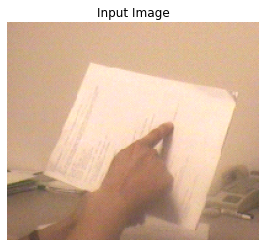

In [7]:
# choose an image and check whether the image is read correctly
curImg = inputImg
display_and_save(curImg, 'Input Image', grayscale=False, save=False)

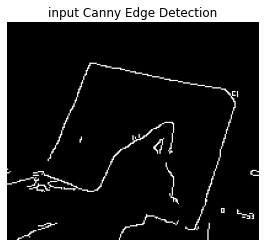

In [8]:
# apply canny edge detector
E = cv.Canny(image=curImg, threshold1=100, threshold2=200)
display_and_save(E, 'input Canny Edge Detection')

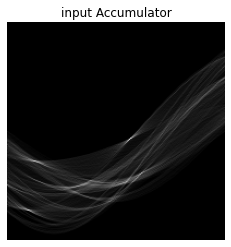

In [9]:
# set the quantization parameters, and calculate different rho and theta values
HEIGHT, WIDTH = 200, 200
ABS_MAX_RHO = (curImg.shape[0]**2 + curImg.shape[1]**2)**0.5
DELTA_RHO = (2 * ABS_MAX_RHO) / HEIGHT
DELTA_THETA = np.pi / WIDTH

# get the hough voting matrix
acc = get_accumulator(E)
display_and_save(acc, 'input Accumulator')

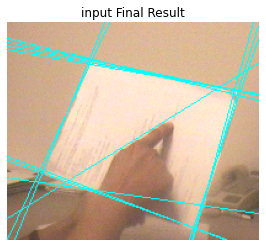

In [10]:
# find local maximas and plot the resulting lines on the image
local_maximas = get_local_maxima(accumulator=acc, threshold=80)
result = draw_lines(curImg, local_maximas)
display_and_save(result, 'input Final Result', grayscale=False)

---

# Second Run
## Image - 'input.bmp' 

## Quantization parameters:
### Accumulator height - 400
### Accumulator width - 400

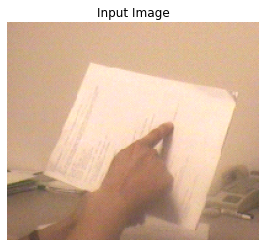

In [11]:
# choose an image and check whether the image is read correctly
curImg = inputImg
display_and_save(curImg, 'Input Image', grayscale=False, save=False)

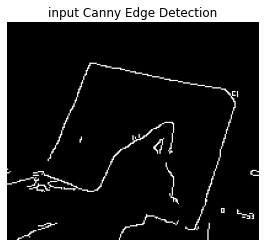

In [12]:
# apply canny edge detector
E = cv.Canny(image=curImg, threshold1=100, threshold2=200)
display_and_save(E, 'input Canny Edge Detection')

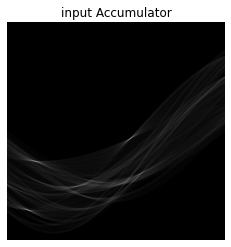

In [13]:
# set the quantization parameters, and calculate different rho and theta values
HEIGHT, WIDTH = 400, 400
ABS_MAX_RHO = (curImg.shape[0]**2 + curImg.shape[1]**2)**0.5
DELTA_RHO = (2 * ABS_MAX_RHO) / HEIGHT
DELTA_THETA = np.pi / WIDTH

# get the hough voting matrix
acc = get_accumulator(E)
display_and_save(acc, 'input Accumulator')

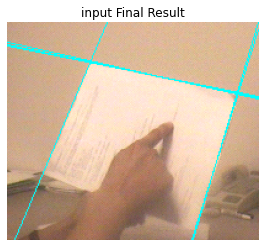

In [14]:
# find local maximas and plot the resulting lines on the image
local_maximas = get_local_maxima(accumulator=acc, threshold=80)
result = draw_lines(curImg, local_maximas)
display_and_save(result, 'input Final Result', grayscale=False)

---

# Third Run
## Image - 'test.bmp' 

## Quantization parameters:
### Accumulator height - 100
### Accumulator width - 100

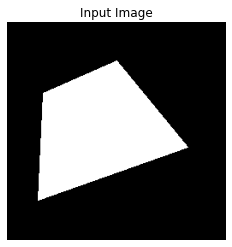

In [15]:
# choose an image and check whether the image is read correctly
curImg = testImg
display_and_save(curImg, 'Input Image', grayscale=False, save=False)

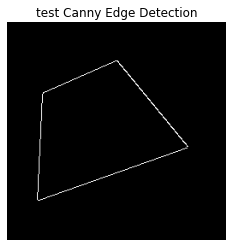

In [16]:
# apply canny edge detector
E = cv.Canny(image=curImg, threshold1=100, threshold2=200)
display_and_save(E, 'test Canny Edge Detection')

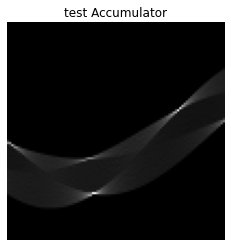

In [17]:
# set the quantization parameters, and calculate different rho and theta values
HEIGHT, WIDTH = 100, 100
ABS_MAX_RHO = (curImg.shape[0]**2 + curImg.shape[1]**2)**0.5
DELTA_RHO = (2 * ABS_MAX_RHO) / HEIGHT
DELTA_THETA = np.pi / WIDTH

# get the hough voting matrix
acc = get_accumulator(E)
display_and_save(acc, 'test Accumulator')

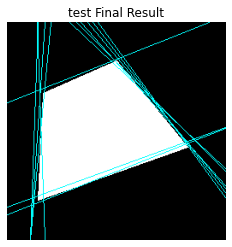

In [18]:
# find local maximas and plot the resulting lines on the image
local_maximas = get_local_maxima(accumulator=acc, threshold=80)
result = draw_lines(curImg, local_maximas)
display_and_save(result, 'test Final Result', grayscale=False)

---

# Fourth Run
## Image - 'test.bmp' 

## Quantization parameters:
### Accumulator height - 500
### Accumulator width - 500

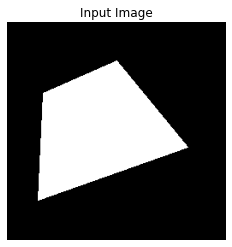

In [19]:
# choose an image and check whether the image is read correctly
curImg = testImg
display_and_save(curImg, 'Input Image', grayscale=False, save=False)

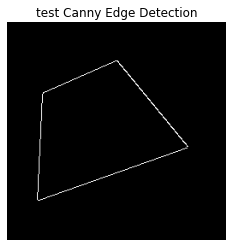

In [20]:
# apply canny edge detector
E = cv.Canny(image=curImg, threshold1=100, threshold2=200)
display_and_save(E, 'test Canny Edge Detection')

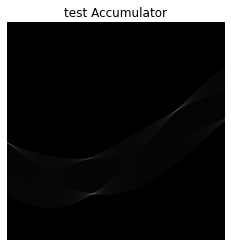

In [21]:
# set the quantization parameters, and calculate different rho and theta values
HEIGHT, WIDTH = 500, 500
ABS_MAX_RHO = (curImg.shape[0]**2 + curImg.shape[1]**2)**0.5
DELTA_RHO = (2 * ABS_MAX_RHO) / HEIGHT
DELTA_THETA = np.pi / WIDTH

# get the hough voting matrix
acc = get_accumulator(E)
display_and_save(acc, 'test Accumulator')

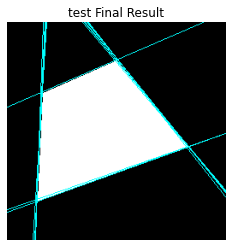

In [22]:
# find local maximas and plot the resulting lines on the image
local_maximas = get_local_maxima(accumulator=acc, threshold=80)
result = draw_lines(curImg, local_maximas)
display_and_save(result, 'test Final Result', grayscale=False)

---

# Fifth Run
## Image - 'test2.bmp' 

## Quantization parameters:
### Accumulator height - 100
### Accumulator width - 100

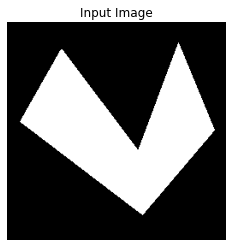

In [23]:
# choose an image and check whether the image is read correctly
curImg = test2Img
display_and_save(curImg, 'Input Image', grayscale=False, save=False)

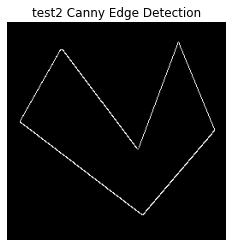

In [24]:
# apply canny edge detector
E = cv.Canny(image=curImg, threshold1=100, threshold2=200)
display_and_save(E, 'test2 Canny Edge Detection')

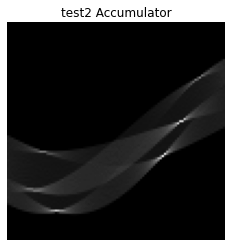

In [25]:
# set the quantization parameters, and calculate different rho and theta values
HEIGHT, WIDTH = 100, 100
ABS_MAX_RHO = (curImg.shape[0]**2 + curImg.shape[1]**2)**0.5
DELTA_RHO = (2 * ABS_MAX_RHO) / HEIGHT
DELTA_THETA = np.pi / WIDTH

# get the hough voting matrix
acc = get_accumulator(E)
display_and_save(acc, 'test2 Accumulator')

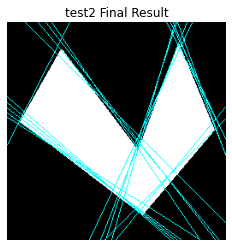

In [26]:
# find local maximas and plot the resulting lines on the image
local_maximas = get_local_maxima(accumulator=acc, threshold=80)
result = draw_lines(curImg, local_maximas)
display_and_save(result, 'test2 Final Result', grayscale=False)

---

# Sixth Run
## Image - 'test2.bmp' 

## Quantization parameters:
### Accumulator height - 500
### Accumulator width - 500

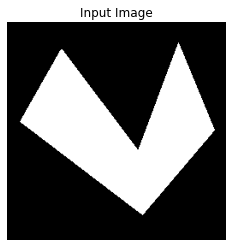

In [27]:
# choose an image and check whether the image is read correctly
curImg = test2Img
display_and_save(curImg, 'Input Image', grayscale=False, save=False)

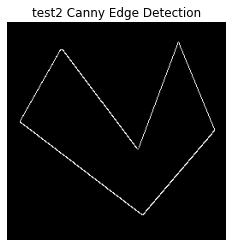

In [28]:
# apply canny edge detector
E = cv.Canny(image=curImg, threshold1=100, threshold2=200)
display_and_save(E, 'test2 Canny Edge Detection')

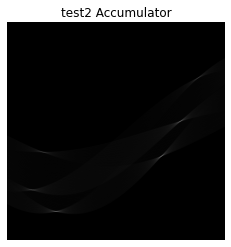

In [29]:
# set the quantization parameters, and calculate different rho and theta values
HEIGHT, WIDTH = 500, 500
ABS_MAX_RHO = (curImg.shape[0]**2 + curImg.shape[1]**2)**0.5
DELTA_RHO = (2 * ABS_MAX_RHO) / HEIGHT
DELTA_THETA = np.pi / WIDTH

# get the hough voting matrix
acc = get_accumulator(E)
display_and_save(acc, 'test2 Accumulator')

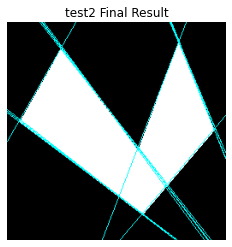

In [30]:
# find local maximas and plot the resulting lines on the image
local_maximas = get_local_maxima(accumulator=acc, threshold=80)
result = draw_lines(curImg, local_maximas)
display_and_save(result, 'test2 Final Result', grayscale=False)

---

# Result Analysis:

1. Running different quantization parameters for the Hough transform yields interesting results.
2. We find changing the quantization drastically changes the final output.
3. We can observe more curves intersecting at the a point for smaller accumulator array.
4. As we have more intersections, a lot of points are above the set threshold for finding the local maxima.
5. Hence, we can see more resulting lines on the output image, all of which may not be entirely accurate.
6. Now for the larger accumulator arrays, the values of intersections are not as high as for the previous experiment.
7. Hence, we obtain fewer points as the local maxima, and they map to fewer resulting lines on the image. To compensate, we can lower the threshold when finding the maxima.
8. In short for the smaller matrix, we may count noise as lines, getting lots of lines where some are inaccurate. In the experiment run 1, we can see the algorithm counting the finger in the image as a line.
9. As we increase the accumulator size, for better quantization, we obtain lesser number of lines (but with lower inaccuracies too). At one stage, we start losing information and the edges we as humans categorize as lines are not recognized as lines by the algorithm.
10. So for experiment run 2, only three edges of the page are counted as lines rather than four.
11. Another interesting point to note here is that noise levels in the image affects our final result.
12. For example, in the experiment runs 3 and 5, we used accumulator size 100 by 100. This gives us lines in the image that we expect to be lines.
13. But for the experiment run 1, even after setting the accumulator size to 200 by 200, we still get some inaccurate information (detecting the finger as a line).
14. Similarly for experiment runs 4 and 6 setting the accumulator size to 500 by 500 gives us desirable result but for the first image, the same parameters gave one or two lines (therefore I used 400 by 400 size in run 2).
15. To conclude, more noise or larger accumulator array means lower overall votes for the local maxima points. So we need to strike the right balance for the hough voting matrix quantization and take into consideration the the image edge noise.